Look at sample lifetimes and under stand some numbers that we might expect if everything works 'well'.

In [1]:
import sys, os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from hl_tables import histogram, count
from hl_tables.atlas import a_3v
from hep_tables import xaod_table
from func_adl import EventDataset

from data import get_ds

In [2]:
ds = get_ds(mH=125, mS=35, lifetime=5, campaign='mc16e')
assert len(ds) == 1
ds

,mH,mS,Lifetime,MCCampaign,RucioDSName,Use,Comments
18,125,35,5,mc16e,mc16_13TeV.311312.MadGraphPythia8EvtGen_A14NNP...,1,NaN


In [3]:
dataset = EventDataset(f'localds://mc16_13TeV:{ds["RucioDSName"].values[0]}')
df = xaod_table(dataset)

In [4]:
truth = df.TruthParticles('TruthParticles')
llp_truth = truth[truth.pdgId == 35]

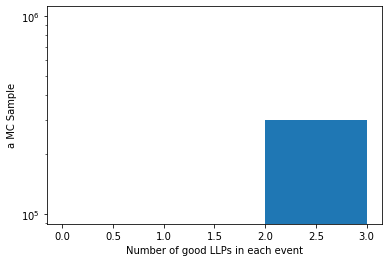

In [5]:
histogram (llp_truth.Count(), bins=3, range=(0,3))
plt.yscale('log')
plt.xlabel('Number of good LLPs in each event')
_ = plt.ylabel('a MC Sample')

In [6]:
llp_good_truth = llp_truth[llp_truth.hasProdVtx & llp_truth.hasDecayVtx]

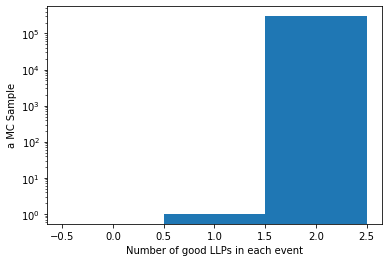

In [7]:
histogram(llp_good_truth.Count(), bins=3, range=(-0.5,2.5))
plt.xlabel('Number of good LLPs in each event')
plt.ylabel('a MC Sample')
plt.yscale('log')

In [14]:
l_prod = a_3v(llp_good_truth.prodVtx)
l_decay = a_3v(llp_good_truth.decayVtx)
lxy = (l_decay+l_prod).xy/1000.0

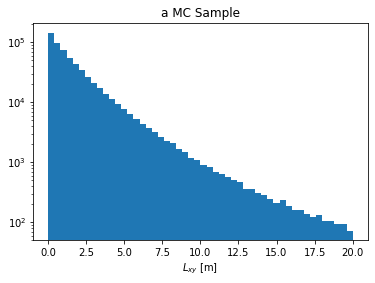

In [15]:
histogram(lxy, bins=50, range=(0,20))
plt.yscale('log')
plt.xlabel('$L_{xy}$ [m]')
_ = plt.title('a MC Sample')

# Some info about the old analyses

1. [CalRatio Internal Note](https://cds.cern.ch/record/2268150)
1. [MSID Internal Note](https://cds.cern.ch/record/2256102)

The general plots for reconstruction efficiency can be seen here. CalRatio is trigger only on the right, and MS reconstruction on the left:

![](CalRatio-Trigger-Eff-Lxy.png)![](MS-Reco-Eff_lxy.png)

It would seem reasonable to use 30% efficency for both, 2.0m-3.5m for the CalRatio, and 4.0m-7.0m for the MS.

In [10]:
from typing import Tuple
class detector_range:
    def __init__(self, name: str, range: Tuple[float, float], eff: float):
        self._name = name
        self._x_min = range[0]
        self._x_max = range[1]
        self._eff = eff
        
    def draw_lxy_box(self):
        x_center = (self._x_max - self._x_min)/2 + self._x_min

        axes = plt.gca()
        y_min = axes.get_ylim()[0]
        y_max = axes.get_ylim()[1] * 0.90
        y_center = (y_max - y_min)/2 + y_min

        plt.text(x_center, y_center, self._name, size=10, ha="center", va="center", color='w')

        r = patches.Rectangle((self._x_min, y_min),self._x_max - self._x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
        plt.gca().add_patch(r)
        axes.add_patch(r)
        
    def inside(self, lxy):
        'Return a max of lxy if lxy is in the range'
        return (lxy > self._x_min) & (lxy <= self._x_max)
        
cal = detector_range('cal', (2.0, 3.5), 0.3)
muon = detector_range('muon', (4.0, 7.0), 0.3)

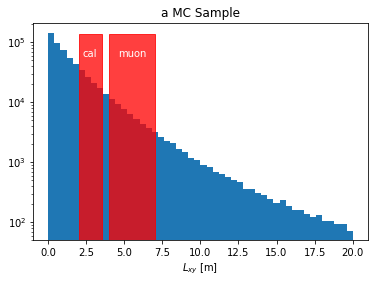

In [11]:
from typing import List
def plot_lxy(lxy, d_info: List[detector_range]):
    histogram(lxy/1000.0, bins=50, range=(0,20))
    for d in d_info:
        d.draw_lxy_box()
    plt.yscale('log')
    plt.xlabel('$L_{xy}$ [m]')
    _ = plt.title('a MC Sample')
    
plot_lxy(lxy, (cal, muon))

Now, calculate the number of times we have a decay in the cal and the muon. Above we were looking at every single LLP in the event that had a good production and decay vertex. For this we have to look at events that have two good LLP's so we can ask questions about each one!

In [16]:
lxy_2 = lxy[lxy.Count() == 2]

# Now, lets count all maner of these things
info = dict(
    total = count(lxy_2),
    # has_1muon = count(lxy_2[muon.inside(lxy_2[0]) | muon.inside(lxy_2[1])]),
    has_1muon = count(lxy_2[lxy_2.mapseq(lambda s: muon.inside(s[0]) | muon.inside(s[1]))]),
    has_1cal = count(lxy_2[lxy_2.mapseq(lambda s: cal.inside(s[0]) | cal.inside(s[1]))]),
    has_2muon = count(lxy_2[lxy_2.mapseq(lambda s: muon.inside(s[0]) & muon.inside(s[1]))]),
    has_2cal = count(lxy_2[lxy_2.mapseq(lambda s: cal.inside(s[0]) & cal.inside(s[1]))]),
    has_calms = count(lxy_2[lxy_2.mapseq(lambda s: (cal.inside(s[0]) & muon.inside(s[1])) | (muon.inside(s[0]) & cal.inside(s[1])))])
)

In [17]:
info

{'total': 299999,
 'has_1muon': 47857,
 'has_1cal': 87556,
 'has_2muon': 2034,
 'has_2cal': 7632,
 'has_calms': 7762}